<a href="https://colab.research.google.com/github/luizleroy/predictive_analytics/blob/develop/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to Predictive Analysis with Colab and Python**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href=""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/luizleroy/predictive_analytics/blob/develop/new.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Welcome to this Colab! I will get a quick introduction to the Analysis with Colab and Python to Predictive Analysis.

Colab is a Python development environment that runs in the browser using Google Cloud.

Agora, vamos na língua de Camões mesmo, hehehe. Pois, o principal objetivo aqui é criar insumos, 'pedaços' de código mesmo, para utilizar em projetos de P&D.

**Algoritmos preditivos**

A proposta via TI para este PD é entregar um sistema com os seguintes grupos de algoritmos:

*   Os situacionais de DEC e FEC, implantando relatórios na plataforma PTC referentes a dados que já existem em outras plataformas nas concecionários hoje.
*   Implementar um grupo de algoritmos preditivos, ou seja, no início do ano, sem informações futuras, devo rodar um cálculo, usando alguma(s) metodologia(s) que prevê(êm) como será o comportamento (DEC, FEC, índices regulamentados) dos circuitos elétricos - ou seja, os conjuntos Aneel - no ano vindouro. Quais conjuntos ficarão acima da meta e quais ficarão dentro (abaixo) da meta?

Para o(s) Algoritmos Preditivos, as informações que temos, no momento, são:
0. Tabelas de metas para DEC e FEC dos conjuntos (informação privada).
1. Topologia da rede elétrica por alimentador e conjunto, onde sei quem é urbano e quem é rural (informação privada).
2. Dados de DEC FEC históricos, creio que com 3 anos de históricos eu consigo ver o comportamento dos conjuntos ao longo do ano (sazonalidades) e consigo fazer através de regressão linear, uma previsão se o conjunto vai manter, abaixar ou superar sua meta se nada for investido nele... **Esta informação é pública, e encontra-se no site da Aneel [aqui](https://www.aneel.gov.br/indicadores-coletivos-de-continuidade)**
3. **Meteorologia** para DEC e FEC: rajada + chuva podem aumentar a quantidade de interrupções (informação pública no site do INMET .gov).

A premissa aqui é que, com os dados acima, os algoritmos preditivos aqui descritos e, o apoio dos parceiros do projeto com unidades computacionais, dicas e conselhos técnicos - possivelmente - conseguiremos implementar a previsão para DEC urbano e rural em toda região da CEMIG.

# Imports

In [1]:
#!pip install sklearn

In [2]:
import numpy as np
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn import svm

from sklearn.model_selection import cross_val_score


from sklearn.svm import SVC

# Possíveis tratamentos

Será necessário tratar dados reais. Sempre é. Deixarei aqui um 'log' para possíveis tratamentos.

Geralmente é considerado o percentual de 5% para o atributo ser considerado Raro, o que causaria overfitting. Em algumas situações onde exitem poucos atributos, pode ser que sejam úteis esses atributos raros. Porém, se a variável possuir muitos atributos, deve ser descartado.

Formas de tratar os atributos raros:
*   Substituir o atributo raro para o atributo mais frequente.
*   Agrupar os atributos em uma nova categoria (exemplo: raro, outros).
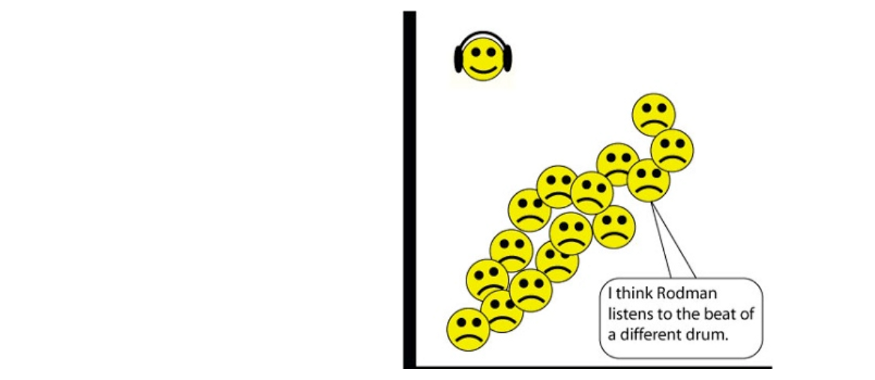

FONTE: https://medium.com/@alegeorgelustosa/an%C3%A1lise-explorat%C3%B3ria-e-preditiva-do-dataset-titanic-em-python-fbd5e5bb7328#

**TODO** inserir os outros tratamentos.

# Dados de entrada - Quarteto de Anscombe

In [3]:
data = pd.read_json('sample_data/anscombe.json')


In [4]:
input_data = data['X']
output_data = data['Y']
X1 = input_data[0:11]
Y1 = output_data[0:11].values
Y2 = output_data[11:22].values
Y3 = output_data[22:33].values

X4 = input_data[33:44].values
Y4 = output_data[33:44].values
ascombe = {
            "X": X1,
            "Y1":Y1,
            "Y2":Y2,
            "Y3":Y3,
            "X4":X4,
            "Y4":Y4,
}
data_para_treinamento_ascombe = pd.DataFrame(ascombe)
print(data_para_treinamento_ascombe)
print('-----------------------------------------------------------------------')
data_para_treinamento_ascombe.describe()

     X     Y1    Y2     Y3  X4     Y4
0   10   8.04  9.14   7.46   8   6.58
1    8   6.95  8.14   6.77   8   5.76
2   13   7.58  8.74  12.74   8   7.71
3    9   8.81  8.77   7.11   8   8.84
4   11   8.33  9.26   7.81   8   8.47
5   14   9.96  8.10   8.84   8   7.04
6    6   7.24  6.13   6.08   8   5.25
7    4   4.26  3.10   5.39  19  12.50
8   12  10.84  9.13   8.15   8   5.56
9    7   4.81  7.26   6.42   8   7.91
10   5   5.68  4.74   5.73   8   6.89
-----------------------------------------------------------------------


,X,Y1,Y2,Y3,X4,Y4
count,11.000000,11.00000,11.000000,11.000000,11.000000,11.000000
mean,9.000000,7.50000,7.500909,7.500000,9.000000,7.500909
std,3.316625,2.03289,2.031657,2.030424,3.316625,2.030579
min,4.000000,4.26000,3.100000,5.390000,8.000000,5.250000
25%,6.500000,6.31500,6.695000,6.250000,8.000000,6.170000
50%,9.000000,7.58000,8.140000,7.110000,8.000000,7.040000
75%,11.500000,8.57000,8.950000,7.980000,8.000000,8.190000
max,14.000000,10.84000,9.260000,12.740000,19.000000,12.500000


# Normalização

**Matriz de correlação, sem Normalização**

Matriz simétrica, de correlação, **R**:
\begin{equation} \bf{R} = \begin{bmatrix} 
r_{11} = 1 & r_{12} & r_{13} & · · · & r_{1p} 
\\ r_{21}& r_{22} = 1  & r_{23} & · · · & r_{2p} 
\\ r_{31} & r_{32} & r_{33}  = 1 & · · · & r_{3p} 
\\ · · · & · · · & · · · & · · · & · · ·
\\ r_{p1} & r_{p2} & r_{p3} & · · · & r_{pp} = 1 
\end{bmatrix}, \end{equation}

onde cada valor acima é a correlação calculada (na fórmula abaixo) entre os vetores **x** de {1,2, ...,p},

\begin{equation*}
  r_{jk} =
  \frac{ \sum_{i=1}^{n}(x_{ij}-\bar{x}_j)(x_{ik}-\bar{x}_k) }{%
        \sqrt{\sum_{i=1}^{n}(x_{ij}-\bar{x}_j)^2}\sqrt{\sum_{i=1}^{n}(x_{ik}-\bar{x}_k)^2}}.
\end{equation*}


Text(0.5, 0.98, 'SEM Normalização')

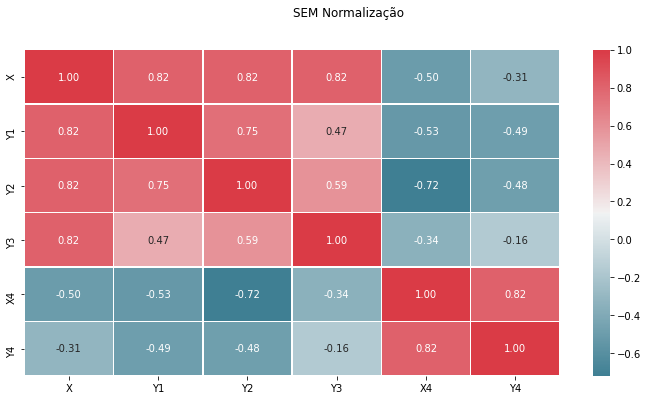

In [5]:
df = pd.DataFrame(data_para_treinamento_ascombe,columns=['X','Y1','Y2', 'Y3', 'X4', 'Y4'])
corrMatrix = df.corr()
cmap = sns.diverging_palette(220,10,as_cmap=True)
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
fig.suptitle("SEM Normalização")

**Matriz de correlação com Normalização**

In [6]:
# scaler = StandardScaler()
# fit = scaler.fit_transform(data_para_treinamento_ascombe)
# dfn = pd.DataFrame(fit,columns=['X','Y1','Y2', 'Y3', 'X4', 'Y4'])
# corrMatrix = dfn.corr()
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# fig, ax = plt.subplots(figsize=(12,6))
# sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
# fig.suptitle("COM Normalização")

# Regressão Logística

Validação inicial:

In [16]:
X = data_para_treinamento_ascombe.iloc[:,1:4]
print(X)
y = data_para_treinamento_ascombe.iloc[:,0]
print('result')
print(y)
clf = SVC(gamma='auto')
clf.fit(X,y)
print('results:')
print('10 ->',clf.predict([[8.04,9.14,7.46]]))
print('8 ->',clf.predict([[6.95,8.14,6.77]]))
print('13 ->',clf.predict([[7.58,8.74,12.74]]))
print('9 ->',clf.predict([[8.81,8.77,7.11]]))
print('11 ->',clf.predict([[8.33,9.26,7.81]]))

       Y1    Y2     Y3
0    8.04  9.14   7.46
1    6.95  8.14   6.77
2    7.58  8.74  12.74
3    8.81  8.77   7.11
4    8.33  9.26   7.81
5    9.96  8.10   8.84
6    7.24  6.13   6.08
7    4.26  3.10   5.39
8   10.84  9.13   8.15
9    4.81  7.26   6.42
10   5.68  4.74   5.73
result
0     10
1      8
2     13
3      9
4     11
5     14
6      6
7      4
8     12
9      7
10     5
Name: X, dtype: int64
results:
10 -> [10]
8 -> [8]
13 -> [13]
9 -> [9]
11 -> [11]


In [7]:
X = data_para_treinamento_ascombe.iloc[:,1:4]
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)
y = data_para_treinamento_ascombe.iloc[:,0]
#y = scaler.fit_transform(y)
print(y)
# TODO preparar outros modelos...
modelos = []
modelos.append(('LR', LogisticRegression()))


[[ 0.27859692  0.8461533  -0.02066187]
 [-0.28375612  0.32992    -0.37707918]
 [ 0.04127362  0.63965998  2.70670532]
 [ 0.6758555   0.65514698 -0.20145326]
 [ 0.42821379  0.90810129  0.16012951]
 [ 1.26916376  0.30927067  0.69217273]
 [-0.13413926 -0.70770892 -0.73349648]
 [-1.67158154 -2.2718958  -1.08991378]
 [ 1.72317356  0.84099097  0.33575543]
 [-1.38782541 -0.12436529 -0.55787056]
 [-0.93897481 -1.42527319 -0.91428787]]
0     10
1      8
2     13
3      9
4     11
5     14
6      6
7      4
8     12
9      7
10     5
Name: X, dtype: int64


In [8]:
resultados = []
nomes = []
#num_folds = 10
#seed = 7
#scoring='accuracy'
for nome, modelo in modelos:
  kfold = model_selection.KFold()
  cv_results = model_selection.cross_val_score(modelo,X,y.values.ravel(),cv=kfold)
  resultados.append(cv_results)
  nomes.append(nome)
  msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())

In [9]:
print(msg)
print(resultados)

LR: 0.000000 (0.000000)
[array([0., 0., 0., 0., 0.])]


# Manter no final: Main_Test :(

In [10]:
# X = pd.DataFrame({'A':range(150)})
# x2 = 5*pd.DataFrame({'B':range(150)})
# X.loc[:,'B'] = x2
# y = 5*pd.DataFrame({'C':range(150)})
# X.shape, y.shape

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# # clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# # clf.score(X_test, y_test)

# clf = svm.SVC(break_ties=kernel='linear', C=1, random_state=42)
# scores = cross_val_score(clf, X_train, y_train, cv=5)
# scores

In [11]:
import numpy as np
X = np.array([[-1,-1], [-2,-1], [1,1], [2,1]])
y = np.array([1,1,2,2])
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X,y)
print(clf.predict([[-0.8,-1]]))

[1]


In [13]:
# randomica = pd.DataFrame(np.random.randint(-500,7000,size=(100, 4)), columns=list('ABCD'))
# df = pd.DataFrame(randomica,columns=['A','B','C','D'])
# print(df)
# corrMatrix = df.corr()
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# fig, ax = plt.subplots(figsize=(12,6))
# sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
# fig.suptitle("SEM Normalização")

# scaler = StandardScaler()
# fit = scaler.fit_transform(randomica)
# dfn = pd.DataFrame(fit,columns=['A','B','C','D'])
# print(dfn)
# corrMatrix = dfn.corr()
# cmap = sns.diverging_palette(220,10,as_cmap=True)
# fig, ax = plt.subplots(figsize=(12,6))
# sns.heatmap(corrMatrix,annot=True,linewidths=0.5,ax=ax,fmt='.2f',cmap=cmap)
# fig.suptitle("COM Normalização")